<a href="https://colab.research.google.com/github/akshayj2518/ReAct-AI-agent-using-Langchain-and-Tavily-/blob/main/ReAct_AI_Agent_using_LangChain_and_Tavily.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install python-dotenv
!pip install -q -U google-generativeai
!pip install langchain langchain-google-genai langchain-openai langchain-community langgraph
!pip install langchain-google-vertexai
# Install system dependencies
!apt-get install -y graphviz libgraphviz-dev pkg-config

# Install pygraphviz
!pip install pygraphviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.2/137.2 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.8/454.8 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.57.4
    Uninstalling openai-1.57.4:
      Successfully uninstalled openai-1.57.4
  Attempting uninstall: langchain-core
    Found existing in

In [2]:
from dotenv import load_dotenv
_ = load_dotenv()

In [12]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_google_genai import ChatGoogleGenerativeAI
# from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
# from langchain_google_vertexai import ChatGoogleGenerativeAI
import google.generativeai as genai
import json
import os
from getpass import getpass


In [4]:
os.environ["TAVILY_API_KEY"] = "YOUR_TAVILY_API_KEY"

tool = TavilySearchResults(max_results=4) #increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


In [7]:
# Prompt for API key input
os.environ["GOOGLE_API_KEY"] = "YOUR_GEMINI_KEY"

genai.configure(api_key='YOUR_GEMINI_KEY')
model = genai.GenerativeModel("gemini-1.5-flash")
response = model.generate_content("Hello world")
response.text.strip()

'Hello there!'

In [8]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [9]:
class Agent:
  def __init__(self, model, tools, system=""):
    self.system = system
    graph = StateGraph(AgentState)
    graph.add_node("llm", self.call_geminiAI)
    graph.add_node("action", self.take_action)
    graph.add_conditional_edges(
        "llm",
        self.exists_action,
        {True: "action", False: END}
    )
    graph.add_edge("action", "llm")
    graph.set_entry_point("llm")
    self.graph = graph.compile()
    self.tools = {t.name: t for t in tools}
    self.model = model.bind_tools(tools)

  def call_geminiAI(self, state: AgentState):
    messages = state['messages']
    if self.system:
      messages = [SystemMessage(content = self.system)] + messages
      # message = model.generate_content(json.dumps(messages))
      message = self.model.invoke(messages)
      return {'messages': [message]}

  def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

  def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0


In [13]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

# model = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
model = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",  # Specify the desired model
    temperature=0.5,         # Adjust temperature as needed
    max_tokens=100           # Set max tokens for response length
)
# model = genai.GenerativeModel("gemini-1.5-flash")
abot = Agent(model, [tool], system=prompt)

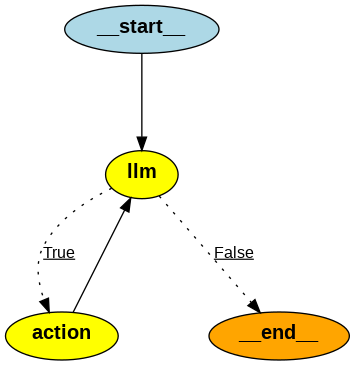

In [14]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

In [27]:
messages = [HumanMessage(content="Who won the super bowl in 2020? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question.")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Who won the super bowl in 2020?'}, 'id': '22d50537-ad2e-4fd4-bb30-63f9b129799b', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Where is the headquarters of the Kansas City Chiefs located?'}, 'id': 'd5881379-a98c-4bfb-999d-bca3210bbbc2', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'What is the GDP of Missouri in 2020?'}, 'id': '7bd14aba-bee6-4c72-a0a4-c127d71a22e4', 'type': 'tool_call'}
Back to the model!


In [29]:
print(result['messages'][-1].content)

The Kansas City Chiefs won Super Bowl 2020.  Their headquarters are in Kansas City, Missouri.  The GDP of Missouri in 2020 was $335,285.1 million.

